# **Projeto Comparação de Algoritmos de Clusterização**

Nosso objetivo será traçar perfis de condições de trabalho que têm correlação com a produtividade de um trabalhador na indústria têxtil.

Conjunto de dados: Garment worker productivity (Link: https://www.kaggle.com/code/dmitriiannenkov/garment-worker-productivity-prediction)


In [72]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# ignorando warnings
warnings.filterwarnings('ignore')

In [55]:
# conectar ao Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
# caminho do arquivo
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/AlgoritmosInteligenciaArtificialClusterizacao/datasets/garments_worker_productivity.csv'
data = pd.read_csv(FILE_PATH)
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [57]:
# explorar os tipos de dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

- aparentemente, todas as variáveis estão com os tipos corretos
- WIP é a única que apresenta valores nulos.

In [58]:
data.isna()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1193,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1194,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1195,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


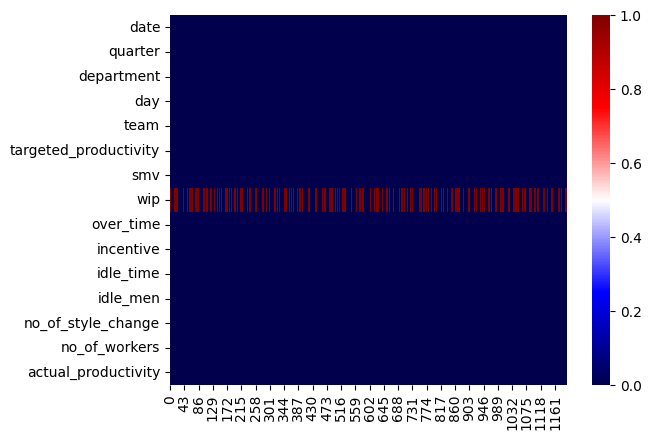

In [59]:
# outra forma de verificar valores nulos - mapa de calor
sns.heatmap(data.isna().T, cmap='seismic')
plt.show()

- o que vamos fazer com dados nulos?
  - eliminar
  - substituir pela média / mediana
  - substituir por zero
  - tentar estimar qual seria o valor (Generative AI*)

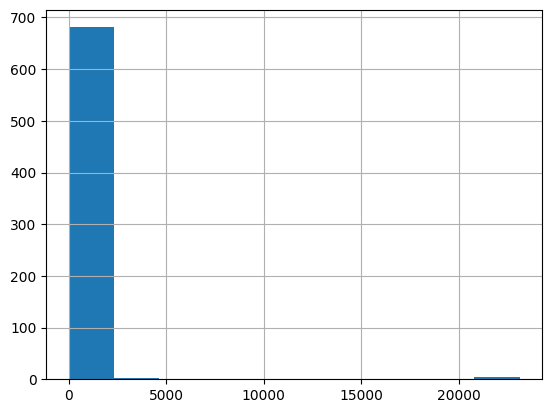

In [60]:
# analisar a distribuição do WIP
data['wip'].hist()
plt.show()


- descobrimos um potencial outlier (> 20 k) além de uma distribuição intensamente assimétrica

In [61]:
# análise estatística
data.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


- **Hipótese**: se WIP = NaN, então podemos considerar que WIP = 0 (validar com o time de negócios)

In [62]:
# substituindo valores NaN por zero
data['wip'].fillna(0, inplace=True)

# verificação de novo de valores nulos
data.isna().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

In [63]:
# vamos eliminar colunas não utilizadas na análise
x = data.copy()
x.drop(columns=['date', 'actual_productivity'], inplace=True)

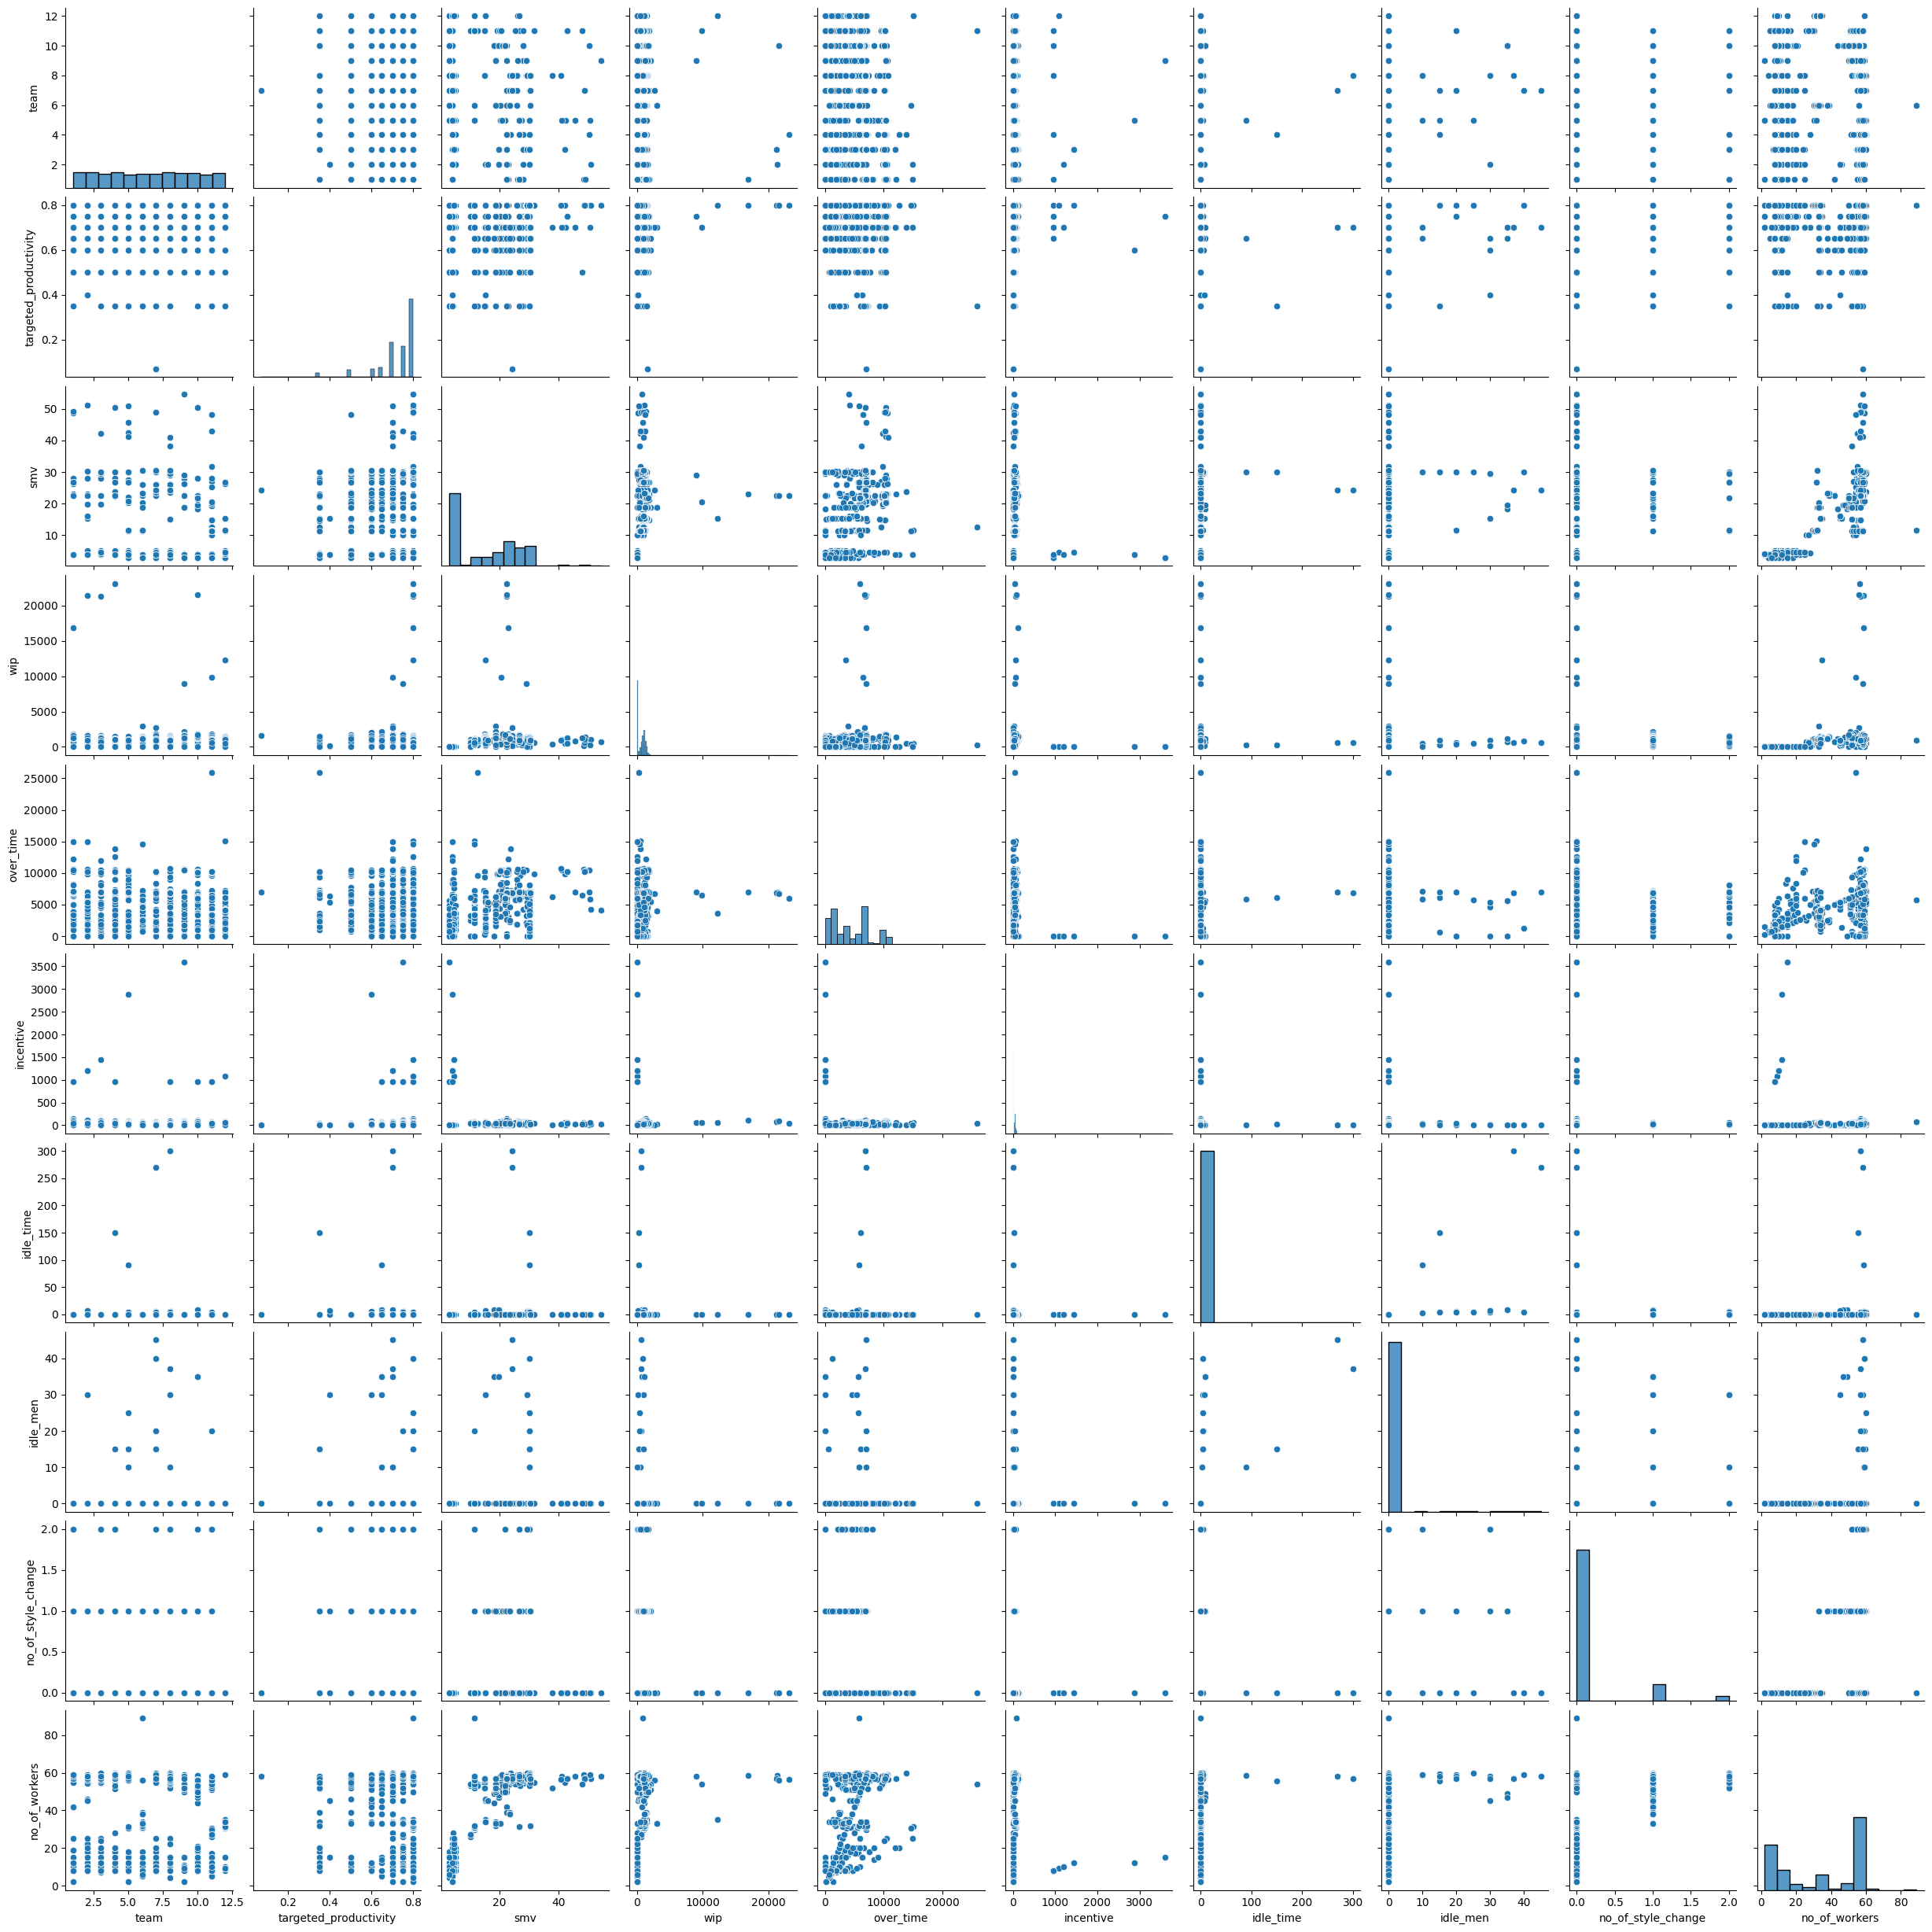

In [64]:
# analisar distribuições
sns.pairplot(x)
plt.show()

- para todas as variáveis, observamos comportamentos bem assimétricos, o que representa grande quantidade de situações "comuns" com alguns poucos exemplos de situações mais raras.
- dica: pode ser que dois grupos sejam identificados na clusterização

<Axes: >

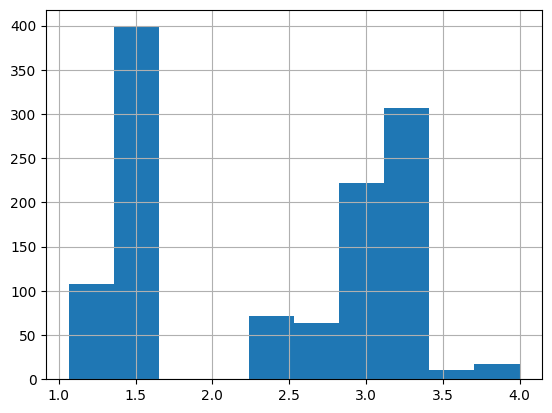

In [65]:
# transformando para eliminar assimetria - SMV
x['smv_transf'] = np.log(x['smv'])
x.drop(columns=['smv'], inplace=True)
x['smv_transf'].hist()

<Axes: >

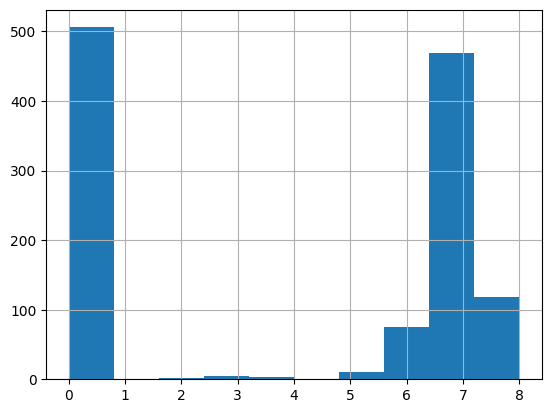

In [66]:
# transformando para eliminar assimetria - WIP
x = x.loc[x['wip'] < 5000, :]
x['wip_transf'] = np.log(x['wip'] + 1)
x.drop(columns=['wip'], inplace=True)
x['wip_transf'].hist()

In [67]:
# categorizar o WIP
x['wip_transf'] = x['wip_transf'].apply(lambda x: 1 if x > 0 else 0)
x.head()

,quarter,department,day,team,targeted_productivity,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,smv_transf,wip_transf
0,Quarter1,sweing,Thursday,8,0.80,7080,98,0.0,0,0,59.0,3.264232,1
1,Quarter1,finishing,Thursday,1,0.75,960,0,0.0,0,0,8.0,1.371181,0
2,Quarter1,sweing,Thursday,11,0.80,3660,50,0.0,0,0,30.5,2.434490,1
3,Quarter1,sweing,Thursday,12,0.80,3660,50,0.0,0,0,30.5,2.434490,1
4,Quarter1,sweing,Thursday,6,0.80,1920,50,0.0,0,0,56.0,3.254243,1


<Axes: >

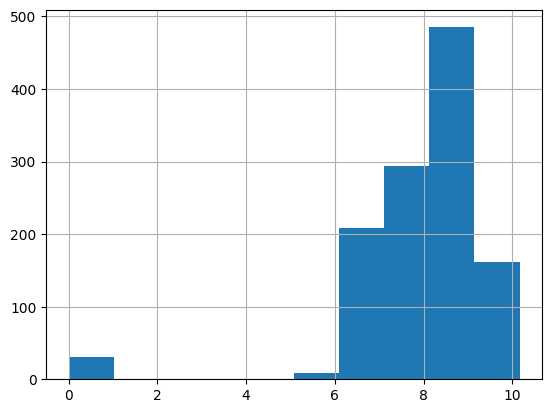

In [68]:
# transformando para eliminar assimetria - overtime
x['over_time_transf'] = np.log(x['over_time'] + 1)
x.drop(columns=['over_time'], inplace=True)
x['over_time_transf'].hist()

<Axes: >

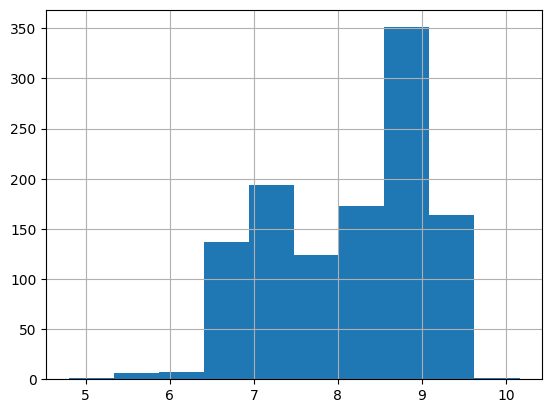

In [69]:
# eliminando valores extremos - perder pessoas que não ganham incentivo
x = x.loc[x['over_time_transf'] > 4,:]
x['over_time_transf'].hist()

In [71]:
# eliminar colunas extremamente desbalanceadas
x.drop(columns=['incentive', 'idle_time', 'idle_men'], inplace=True)
x.head()

,quarter,department,day,team,targeted_productivity,no_of_style_change,no_of_workers,smv_transf,wip_transf,over_time_transf
0,Quarter1,sweing,Thursday,8,0.80,0,59.0,3.264232,1,8.865170
1,Quarter1,finishing,Thursday,1,0.75,0,8.0,1.371181,0,6.867974
2,Quarter1,sweing,Thursday,11,0.80,0,30.5,2.434490,1,8.205492
3,Quarter1,sweing,Thursday,12,0.80,0,30.5,2.434490,1,8.205492
4,Quarter1,sweing,Thursday,6,0.80,0,56.0,3.254243,1,7.560601


In [73]:
# verificando distribuição dos quarters
x['quarter'].value_counts()

Quarter1    348
Quarter2    315
Quarter4    247
Quarter3    204
Quarter5     44
Name: quarter, dtype: int64

- quarter5 muito desbalanceado do resto dos dados - vamos eliminar essas linhas

In [74]:
x = x.loc[x['quarter'] != 'Quarter5', :]
x['quarter'].value_counts()

Quarter1    348
Quarter2    315
Quarter4    247
Quarter3    204
Name: quarter, dtype: int64

In [75]:
# verificando distribuição dos department
x['department'].value_counts()

sweing        639
finishing     239
finishing     236
Name: department, dtype: int64

- finishing parece ter valores com erros de digitação -> precisamos corrigir

In [77]:
x['department'] = x['department'].apply(lambda x: 'finishing' if x in ['finishing ', 'finishing'] else 'sweing')
x['department'].value_counts()

sweing       639
finishing    475
Name: department, dtype: int64

In [78]:
# verificando distribuição dos days
x['day'].value_counts()

Sunday       202
Wednesday    202
Tuesday      194
Monday       178
Thursday     176
Saturday     162
Name: day, dtype: int64

- fizemos as transformações necessárias para a modelagem
- ainda pode ser melhorada, dependendo das respostas de negócio que queremos

In [79]:
# criar um transformador de variáveis categóricas
cat_transform = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ['quarter', 'department', 'day'])
], remainder='passthrough')

In [86]:
def s_score_kmeans(x, n_clusters, cat_transform=cat_transform):

  # crio um pipeline de transformação
  transf = Pipeline([
      ('transform', cat_transform),
      ('scaler', RobustScaler())
  ])

  # treinar e aplicar o transformar
  x_std = transf.fit_transform(x)

  # aplicar o modelo KMeans
  model = KMeans(n_clusters=n_clusters, init='k-means++')
  model.fit(x_std)

  # obtêm os grupos
  labels = model.labels_

  return silhouette_score(x_std, labels)

In [90]:
# aplicando o método da silhueta com KMeans
n_clusters = range(2, 21)
s_score_km = []

for n in n_clusters:
  s_score_km.append(s_score_kmeans(x, n))

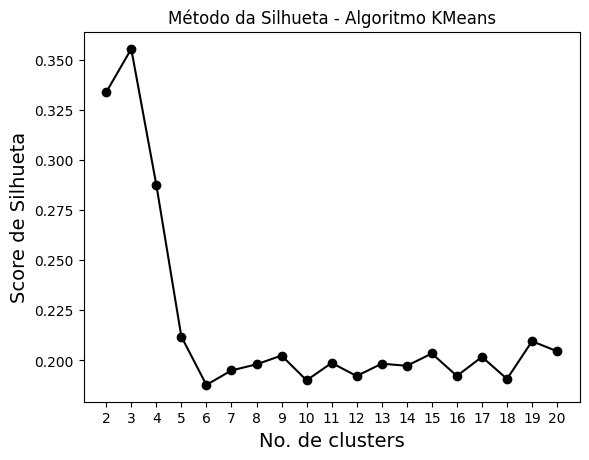

In [91]:
# construindo o método do score de silhueta
plt.plot(n_clusters, s_score_km, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('Score de Silhueta', size=14)
plt.title('Método da Silhueta - Algoritmo KMeans')
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.show()

In [92]:
def s_score_HC(x, n_clusters, linkage, cat_transform=cat_transform):

  # crio um pipeline de transformação
  transf = Pipeline([
      ('transform', cat_transform),
      ('scaler', RobustScaler())
  ])

  # treinar e aplicar o transformar
  x_std = transf.fit_transform(x)

  # aplicar o modelo AgglomerativeClustering
  model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
  model.fit(x_std)

  # obtêm os grupos
  labels = model.labels_

  return silhouette_score(x_std, labels)

In [95]:
s_score_hc = {
    'single': [],
    'complete': [],
    'ward': [],
    'average': []
}

for link in s_score_hc:
  for k in n_clusters:
    s_score_hc[link].append(s_score_HC(x=x, n_clusters=k, linkage=link))

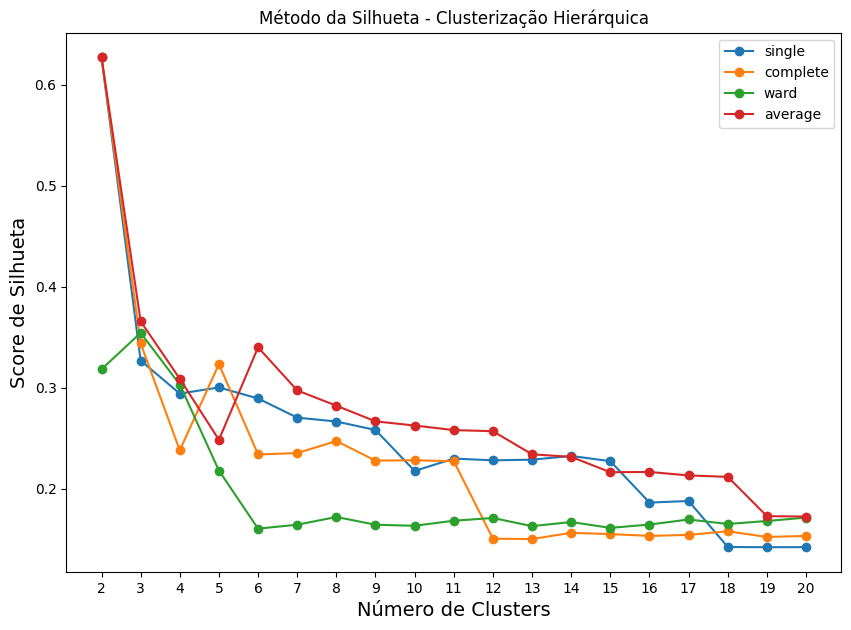

In [96]:
# construindo um gráfico de scores de silhueta
plt.figure(figsize=(10, 7))
for link in s_score_hc:
  plt.plot(n_clusters, s_score_hc[link], 'o-', label=link)
plt.xlabel('Número de Clusters', size=14)
plt.ylabel('Score de Silhueta', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.title('Método da Silhueta - Clusterização Hierárquica')
plt.legend(loc='best')
plt.show()

In [97]:
def s_score_DBSCAN(x, n_clusters, eps, n_min, cat_transform=cat_transform):

  # crio um pipeline de transformação
  transf = Pipeline([
      ('transform', cat_transform),
      ('scaler', RobustScaler())
  ])

  # treinar e aplicar o transformar
  x_std = transf.fit_transform(x)

  # aplicar o modelo AgglomerativeClustering
  model = DBSCAN(eps=eps, min_samples=n_min)
  model.fit(x_std)

  # obtêm os grupos
  labels = model.labels_

  return silhouette_score(x_std, labels)

In [100]:
# analisando influência dos parâmetros
eps = [0.01, 0.1]
min_points = [1, 5, 20]
n_clusters = range(2, 21)
s_score_dbscan = {}

for e in eps:
  for n in min_points:
    s_score_dbscan[f'{e}_{n}'] = []
    for k in n_clusters:
      try:
        s_score_dbscan[f'{e}_{n}'].append(s_score_DBSCAN(x=x, n_clusters=k, eps=e, n_min=n))
      except:
        s_score_dbscan[f'{e}_{n}'].append(0)

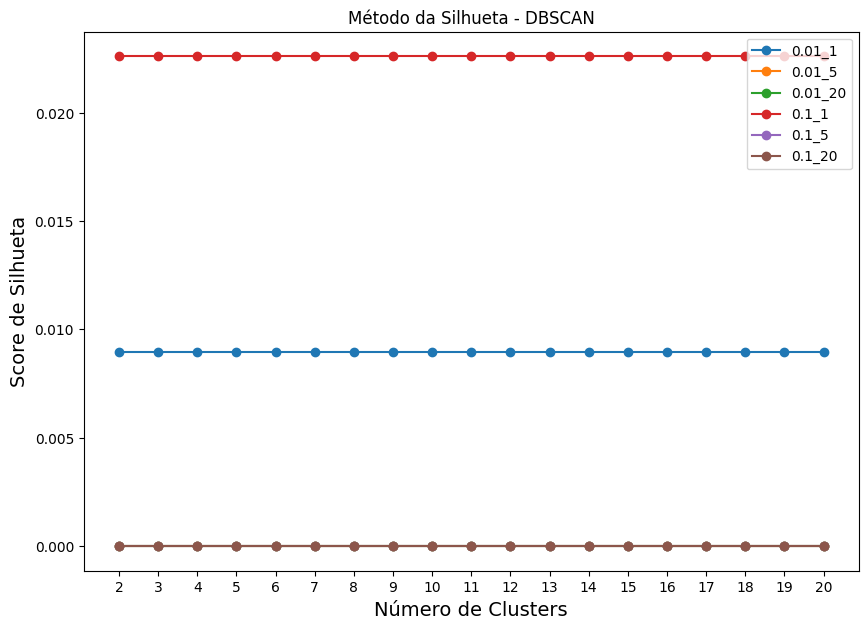

In [101]:
# construindo um gráfico de scores de silhueta
plt.figure(figsize=(10, 7))
for link in s_score_dbscan:
  plt.plot(n_clusters, s_score_dbscan[link], 'o-', label=link)
plt.xlabel('Número de Clusters', size=14)
plt.ylabel('Score de Silhueta', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.title('Método da Silhueta - DBSCAN')
plt.legend(loc='best')
plt.show()

In [102]:
# vamos analisar os clusters - KMeans
data_kmeans = x.copy()

# vamos aplicar o modelo selecionado
# crio um pipeline de transformação
transf = Pipeline([
    ('transform', cat_transform),
    ('scaler', RobustScaler())
])

# treinar e aplicar o transformar
x_std = transf.fit_transform(x)

# aplicar o modelo KMeans
model = KMeans(n_clusters=3, init='k-means++')
model.fit(x_std)

# obtêm os grupos
labels = model.labels_

data_kmeans['cluster'] = labels

In [104]:
# analisar os perfis dos clusters
data_kmeans.groupby(['cluster']).describe().T

cluster                               0           1           2
team                  count  555.000000  448.000000  111.000000
                      mean     6.531532    6.375000    6.090090
                      std      3.450579    3.491440    3.166729
                      min      1.000000    1.000000    1.000000
                      25%      4.000000    3.000000    4.000000
                      50%      6.000000    7.000000    5.000000
                      75%      9.000000    9.000000    8.000000
                      max     12.000000   12.000000   12.000000
targeted_productivity count  555.000000  448.000000  111.000000
                      mean     0.754865    0.756027    0.489369
                      std      0.049307    0.055234    0.102241
                      min      0.650000    0.600000    0.070000
                      25%      0.700000    0.700000    0.375000
                      50%      0.750000    0.800000    0.500000
                      75%      0.800000    0.800000    0.600000
                      max      0.800000    0.800000    0.600000
no_of_style_change    count  555.000000  448.000000  111.000000
                      mean     0.237838    0.000000    0.369369
                      std      0.524844    0.000000    0.570931
                      min      0.000000    0.000000    0.000000
                      25%      0.000000    0.000000    0.000000
                      50%      0.000000    0.000000    0.000000
                      75%      0.000000    0.000000    1.000000
                      max      2.000000    0.000000    2.000000
no_of_workers         count  555.000000  448.000000  111.000000
                      mean    52.090090   10.296875   43.139640
                      std      9.921260    4.092202   19.344622
                      min     26.000000    2.000000    8.000000
                      25%     52.000000    8.000000   33.000000
                      50%     57.000000    8.000000   55.000000
                      75%     58.000000   10.250000   57.000000
                      max     89.000000   28.000000   59.000000
smv_transf            count  555.000000  448.000000  111.000000
                      mean     3.102378    1.342075    2.688559
                      std      0.321722    0.163129    0.778855
                      min      2.307573    1.064711    1.064711
                      25%      2.933325    1.360977    2.434490
                      50%      3.114848    1.371181    3.034472
                      75%      3.335058    1.423108    3.286156
                      max      3.999301    1.635106    3.874944
wip_transf            count  555.000000  448.000000  111.000000
                      mean     1.000000    0.000000    0.756757
                      std      0.000000    0.000000    0.430987
                      min      1.000000    0.000000    0.000000
                      25%      1.000000    0.000000    1.000000
                      50%      1.000000    0.000000    1.000000
                      75%      1.000000    0.000000    1.000000
                      max      1.000000    0.000000    1.000000
over_time_transf      count  555.000000  448.000000  111.000000
                      mean     8.701719    7.385570    8.398605
                      std      0.551938    0.585433    0.798158
                      min      4.795791    5.484797    5.888878
                      25%      8.438282    6.867974    7.855662
                      50%      8.830689    7.273093    8.794976
                      75%      9.043223    7.678326    8.848078
                      max      9.623840    9.615872   10.162809

**Perfis encontrados**

- Grupo 0
  - metas de produtividade entre 75 - 80 %
  - podem ter até 2 trocas de SKU / dia
  - entre 26 e 89 trabalhadores no time
  - log_smv entre 2.3 - 4
  - log_wp = 1 (possuem trabalho pendente)
  - log_over_time entre 4.8 - 9.6
- Grupo 1
  - metas de produtividade entre 75 - 80 %
  - sem trocas de SKU
  - entre 2 e 28 trabalhadores no time
  - log_smv - 1.1 - 1.6
  - log_wip = 0 (sem trabalho pendente)
  - log_over_time = 5.9 - 10.
- Grupo 2
  - metas de produtividade entre 7 e 60 %
  - podem ter até 2 trocas de SKU / dia
  - entre 9 e 59 trabalhadores por time
  - log_smv - 1 - 3.9
  - log_wip = 1 (possuem trabalho pendente)
  - log_over_time = 6 - 10

In [105]:
# analisar variáveis categóricas
pd.crosstab(data_kmeans['cluster'], data_kmeans['quarter'])

quarter,Quarter1,Quarter2,Quarter3,Quarter4
cluster,,,,
0,183,150,103,119
1,145,126,76,101
2,20,39,25,27


In [106]:
# analisar variáveis categóricas
pd.crosstab(data_kmeans['cluster'], data_kmeans['department'])

department,finishing,sweing
cluster,,
0,0,555
1,448,0
2,27,84


In [107]:
# analisar variáveis categóricas
pd.crosstab(data_kmeans['cluster'], data_kmeans['day'])

day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
cluster,,,,,,
0,92,77,102,88,98,98
1,70,67,84,68,76,83
2,16,18,16,20,20,21
